In [38]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path

In [2]:
file = loadmat('/home/sbarc/students/nash/data/var.mat')
lon = file['lon1']
lat = file['lat1']
var = file['var']

In [3]:
## Subset spatial region
latidx1 = np.where(lat == 30)
latidx2 = np.where(lat == -30)
lonidx1 = np.where(lon == 0)
lonidx2 = np.where(lon == 357)

latidx1 = latidx1[0]
latidx2 = latidx2[0]
lonidx1 = lonidx1[0]
lonidx2 = lonidx2[0]
print(latidx1)

[20]


In [4]:
lat2 = lat[20:40,0]
lon2 = lon[0:119,0]
x = var[0:119, 20:40, :]
[numlons, numlats, numtimes] = x.shape
x.shape
x.shape

(119, 20, 456)

In [5]:
## flatten lat and lon into 1 spatial location identifier
X = np.reshape(x, [numlons*numlats, numtimes])
X.shape

X_var = np.reshape(var, [120*61, numtimes])

In [6]:
X_t = np.transpose(X)
X_t.shape

(456, 2380)

In [7]:
## Compute Covariance Matrix
A = np.matmul(X,X_t)
A.shape

(2380, 2380)

In [8]:
## Compute the eigenvalues
d, v = np.linalg.eig(A)
print(d.shape)
print(v.shape)

(2380,)
(2380, 2380)


In [9]:
# eigval = np.diag(d)
# eigval.shape
# print(eigval)
# v = np.fliplr(v)
# print(v.shape)

In [10]:
mode1_orig = v[:,0]
mode1 = np.reshape(mode1_orig, [numlons, numlats])
print(mode1.shape)

(119, 20)


In [11]:
mode1_t = np.transpose(mode1)
mode1_t.shape

(20, 119)

/home/nash/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:2788: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


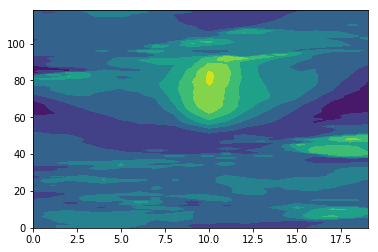

In [12]:
plt.contourf(mode1)

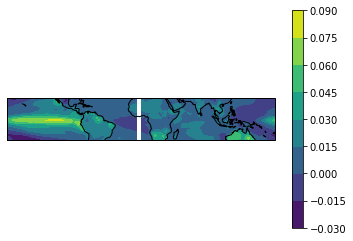

In [13]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon2.min(), lon2.max(), lat2.min(), lat2.max()], crs=ccrs.PlateCarree())
cf = plt.contourf(lon2, lat2, mode1_t)
plt.colorbar(cf)
ax.coastlines()
plt.show()

In [27]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

## create array of times - daily between Jan 1, 1979 and Dec 31, 2017
def date_range(start_date, end_date, increment, period):
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta
    return result

start = str('1979-01-15')
end = str('2016-12-15')
start_date = datetime.strptime(start, '%Y-%m-%d')
end_date = datetime.strptime(end, '%Y-%m-%d')
times_list = date_range(start_date, end_date, 1, 'months')
times = np.array(times_list)
print(times.shape)

(456,)


In [41]:
var_t = np.transpose(var)
var_t.shape

(456, 61, 120)

In [45]:
sst.lat

<xarray.DataArray 'lat' (lat: 61)>
array([ 90.,  87.,  84.,  81.,  78.,  75.,  72.,  69.,  66.,  63.,  60.,  57.,
        54.,  51.,  48.,  45.,  42.,  39.,  36.,  33.,  30.,  27.,  24.,  21.,
        18.,  15.,  12.,   9.,   6.,   3.,   0.,  -3.,  -6.,  -9., -12., -15.,
       -18., -21., -24., -27., -30., -33., -36., -39., -42., -45., -48., -51.,
       -54., -57., -60., -63., -66., -69., -72., -75., -78., -81., -84., -87.,
       -90.], dtype=float32)
Coordinates:
  * lat      (lat) float32 90.0 87.0 84.0 81.0 78.0 ... -81.0 -84.0 -87.0 -90.0

In [46]:
## load dataset into xarray
## Read all data into single xarray dataset 
## this makes it easier to index bounds and do climatology stuff
ds = xr.Dataset({'sst': (['time', 'lat', 'lon'], var_t)},
                coords={'time': times,
                        'lat': (['lat'], lat[:,0]),
                        'lon': (['lon'], lon[:,0])})
sst = ds.sst.sel(lat=slice(30, -30))

In [47]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst, weights=wgts)

solver

In [51]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofs(neofs=1)
pc1 = solver.pcs(npcs=1, pcscaling=1)

eof1.shape

(1, 21, 120)

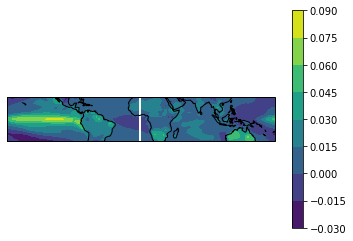

In [53]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([sst.lon.min(), sst.lon.max(), sst.lat.min(), sst.lat.max()], crs=ccrs.PlateCarree())
cf = plt.contourf(sst.lon, sst.lat, eof1[0,:,:]*-1)
plt.colorbar(cf)
ax.coastlines()
plt.show()